# Prerequisites

In [1]:
import os
import sys 
if os.name == 'nt' : 
    # add quotes around directories with spaces in path because windows is dumb
    pyexe = os.path.sep.join([('\"'+x+'\"' if ' ' in x else x) for x in sys.executable.split(os.path.sep)])
else :
    pyexe = sys.executable
print("Your Python executable is at : ", pyexe)

### install packages for the given code 
# !{pyexe} -m pip install treys
# !{pyexe} -m pip install termcolor
# !{pyexe} -m pip install pandas
# 
### install / upgrade necessary packages 
# !{pyexe} -m pip install --upgrade pip
# !{pyexe} -m pip install matplotlib 
# !{pyexe} -m pip install --upgrade scipy
# !{pyexe} -m pip install --upgrade scikit-image

Your Python executable is at :  c:\users\"michael biselx"\appdata\local\programs\python\python38-32\python.exe


In [2]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
from treys import Card
from termcolor import colored
from utils import eval_listof_games, debug_listof_games, save_results, load_results, print_color

# homemade stuff
from preprocessing import *
from evaluate_cards import *

# IAPR: Project Report


**Group ID:** 37

**Author 1 (sciper):** Michael Biselx (283812)  
**Author 2 (sciper):** Bastien Darbellay (288406)   
**Author 3 (sciper):** Maria Guerraoui (274578)   

**Release date:** 29.04.2022



## Introduction 
An anonymous card player named Bartick Pruel wishes to improve his poker skills. To do so, he has asked the Signal Processing lab to design a tool that will automatically detect the hands of the players around the table. <br><br>

<div>
<img src="media/Bartick_Pruel.jpg" width="200"/>
</div>

The Signal Processing lab has subcontracted this task to the students of the course EE-451 : Image Analysis and Pattern Recognition. 



## Methods

The given task can be broken down into several critical steps. 

### Preprocessing 

Before anything else, we do some preprocessing on the image, to make it more uniform and easier to work with later on.

#### Table Registration 

The very first step is to register the table. This consist of detecting the edges/corners of the table and applying a geometric transform to the image to place these corners into the corners of the image.
This guarantees that only the table is visible and that there will be no false detection of objects off the table surface. 

The method used for this is the Hough Line transform on the detected edges. In order to reduce the computation time for this intensive calculation, we downsample and grayscale the image first.

<div>
<img src="media/registration_1.png" width="500"/>
</div>


#### Color/Lighting Correction

Once the table has been registered, we try to remove the variance due to lighting conditions. This is done by forcing the mean value of all images to 0.7 (on a range [0,1]). 
Then, to avoid losing potentially relevant information, rather than clipping the image back to a range of [0,1], we pass the image through a modified sigmoid function.

This makes segmenting by color much simpler in later operations. 


<div>
<img src="media/equalization_1.png" width="500"/>
</div>

#### Segmentation

Once the image has been color corrected, different operations must be performed on different regions. Hence, we cut the image into different segments, each of which is treated differently afterwards. 
Segmentation is performed according to the overlay given in the exercise specifications.

<div>
<img src="media/segmentation_2.png" width="500"/> 
</div>

#### Code Demo

---- 0.355 seconds to extract players
---- 0.000 seconds to extract community cards
---- 0.000 seconds to extract chips


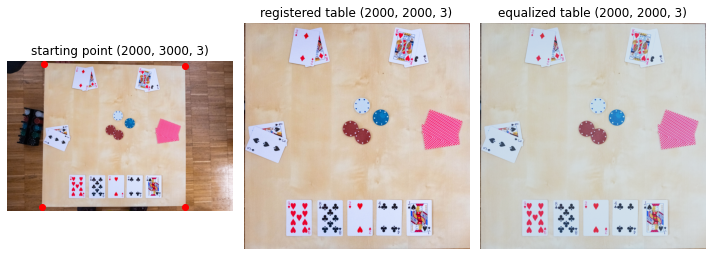

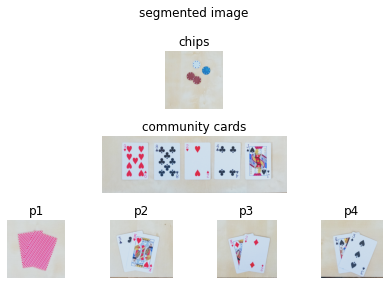

In [3]:
game_id = 1

# the starting point
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
img = get_img(game_id)[::2, ::2, :] # downsample because laptop can't handle the big image
show_img(img, 'starting point', ax=axes[0])

# register the table
table, corners = register_table(img, autoscale=True)
axes[0].scatter(corners[:,0], corners[:,1], color='r')
show_img(table,    'registered table', ax=axes[1])
del img

# apply color/brightness equalization
table_eq = apply_statistical_equalization(table, target_std=None)
show_img(table_eq, 'equalized table',  ax=axes[2])
del table, corners

# segment table 
segments = TableSegments(table_eq, is_registered=True, is_equalized=True)
segments.show('segmented image')
del table_eq

# show the stuff
plt.show()

# free memory
segments.save(game_id)
del segments

### Chip Counting


The first big challenge is to count the number of chips present in the pot. This is accomplished through a combination of HSV-space thresholding and the Hough Circle transform. 

First, the image is separated into regions corresponding to the different colors using the HSV color space. Then the areas of the contours corresponding most to a circle of the right dimension are extracted using a Hough transform. These are considered to be chips of the appropriate color. 

<div>
<img src="media/chips_counting_1.png" width="500"/> 
</div>


The main issue we had with this part of the project was the separation of the white chips from the bright background. Indeed, we were not able to find a good thresholding level either in RGB, HSV or grayscale images, thus making the "detection" of white chips rather arbitrary.  

#### Code Demo

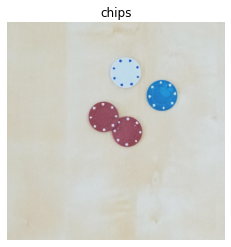

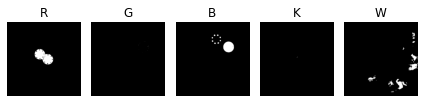

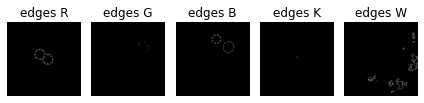

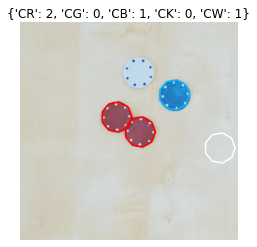

In [4]:
img = get_img(game_id, img_type='chips')
chips = ChipsSegment(img, cropped=True)

chips.show()
chips.get_nb_chips(show=True)
plt.show()

del img, chips

### Card Recognition

One of the biggest challenges in this project was to find a way to detect the value of the cards. 
After several tries, we settled on a method based on Fourier descriptors. 

####  Fold Detection

Before attempting to read the cards, we try to determine if the player has folded or not. We do this by checking for the presence of the diamond pattern on the backs of the cards, using autocorrelation, which lets the highly repetitive pattern stand out.

<div>
<img src="media/card_backs_1.png" width="400"/> 
</div>


####  Symbol Extraction

We started by creating a model composed of the average 'ideal' descriptors for each symbol we can expect to find on the cards (i.e. each digit and each suit). 

<div>
<img src="media/contour_1.png" width="200"/> 
</div>

We then extract the contours from the image we want to analyze and compare their descriptors to these 'ideal' descriptors to find the closest match. 
If no match is found, the contour is discarded as noise. Nonetheless, this process is noisy and produces a number of false detections.

One big issue with this approach arises from its main advantage : rotational insensitivity. We were unfortunately not able to find a solution which was robust to small-angle rotations, and yet gave still gave the information on the general orientation of the symbo (i.e. 'upside-down' or 'right side up'). 
Due to the font used on the cards, it is therefore impossible to tell the difference between a `'6'` and a `'9'`, and the value is randomly assigned.
Some attempts were made to remedy this by extracting the rotation of the contour from the phase of the Fourier descriptors, however little success was gained this way. 


####  Card Estimation

When all symbols have been extracted, we must try to recognize the cards from their patterns. 

The easiest pattern to recognize is the attribution of suit and value. This is done by looking at each value symbol and assigning the closest suit symbol to it. Thus, a `'K'` close to a `'D'` becomes `'KD'`. 

Next, we attempt to determine if any cards are fully visible. This can be done by checking if there are any two similar value symbols within the distance given by the diagonal of a card. If it is the case, the two are combined into a single doubly-detected card.

If insufficient cards are detected this way, the most likely singly detected values are promoted to cards as well, until the expected number of cards is reached. 


#### Code Demo

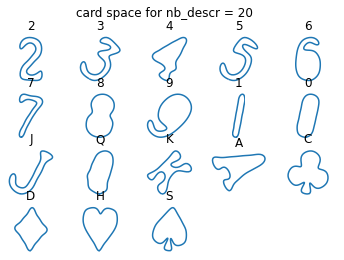

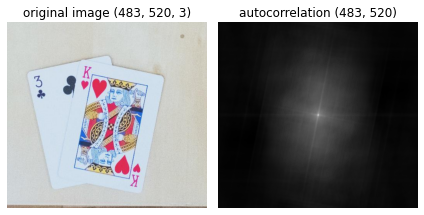

cards detected, in order of certainty : ['KH', '3C']


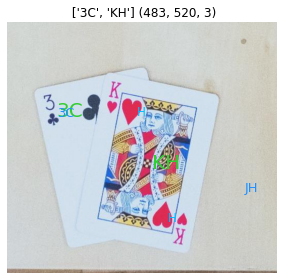

In [5]:
# show the "card space"
card_space = load_card_space(filename="cardspace_20.pkl")
show_card_space(card_space)
plt.show()

# demonstrate on a hand of cards
#img = get_img(game_id, img_type='cards1')
img = get_img(game_id, img_type='cards2')
has_folded = check_card_back_presence(img, show=True)
plt.show()
if has_folded : 
    print("player has folded")
else :
    guess = guess_cards(img, card_space, nb_cards=2, disp=True)
    print("cards detected, in order of certainty :", [card[0] for card in guess])
    plt.show()

del card_space, img

## Structure
### Structure of the Project Code

The software written for this project is orgnized over two external python modules. 

The main module is `preprocessing.py`, which declares the different image segment objects and their methods, including the methods for counting the number of chips present in a `ChipsSegment`.

The second module is `evaluate_cards.py`, which does all the work relative to detecting the card symbols in an image and recognizing the patterns which make up a card.


### Structure of the File System

The minimum data file system is constructed as follows : 

```
data 
│
└─── models
│    │    cardspace_10.pkl    # model containing 10 descriptors of symbol contours
│    │    cardspace_20.pkl    # model containing 20 descriptors of symbol contours
│    │    ...
│    └─── cardspace_100.pkl    # model containing 100 descriptors of symbol contours
│
└─── train
│    │    train_00.jpg        # Train image 00
│    │    ...
│    │    train_27.jpg        # Train image 27
│    │    train_99.jpg        # An image of Lena, to try and break the code
│    └─── train_labels.csv    # Ground truth of the train set
│
└─── test
     │    test_00.jpg         # Test image 00 (day of the exam only)
     │    ...
     └─── test_xx             # Test image xx (day of the exam only)
```
The `preprocessing.py` module can (and will) create additional directories if asked to save its intermediate results.


## Results 

### Runtime

Our algorithm is relatively heavy, and takes quite a bit of time to run for a single image. Depending on the computer, it can take between 5 and 10 seconds per image.

This is partially due to the preprocessing step, which can take up to 2 - 3 seconds, mostly for te image registration. 

The evaluation of the different segments can take anywhere from 2 to 5 seconds. It must be admitted that the logic for the card estimation is not very efficient, and could definitely benefit from some streamlining. 


### Training Set

On the training set, we can achieve a score as high as 97% (for game 9, where only a single `'6'` was misclassified as a `'9'`).

However, there are also games where our algorithm perfoms much less well. One such game is game 4, where our algorithm's score falls as low as 38%. This is due to the blurriness of the image, which leads to garbage detections. 

In general, our algorithm seems to do fairly well though, achieving scores of 75% to 90% on most training images.


In [9]:
from utils import print_color

def process_image(img, save_intermed=False, n=0, show=False) : 
    
    tic = time.time()
    print("-- segmenting image : ")
    try : 
        segments = TableSegments(img)
    except (AssertionError) as e: 
        print(e)
        print_color("Assuming this means that a bad image was given as input:\n")
        show_img(img)
        plt.show()
        print_color("Breaking here and returning empty dict\n")
        return dict()
    print("-- %.3f seconds to segment image" % (time.time() - tic))
    
    if save_intermed : 
        tic = time.time()
        print("-- saving segments : ")        
        segments.save(n)
        print("-- %.3f seconds to save image segments" % (time.time() - tic))
    
    tic = time.time()
    print("-- evaluating image : ")
    results = segments.evaluate()
    print("-- %.3f seconds to evaluate image" % (time.time() - tic))
    
    if show : segments.show("train_{}.jpg".format(str(n).zfill(2)))
    
    return results


processing img 0:
-- 0.508 seconds to load image
-- segmenting image : 
---- 2.225 seconds to register table
---- 0.672 seconds to equalize table
---- 0.483 seconds to extract players
---- 0.000 seconds to extract community cards
---- 0.000 seconds to extract chips
-- 3.388 seconds to segment image
-- evaluating image : 
---- 2.065 seconds to count community cards
---- 2.898 seconds to count player cards
---- 1.299 seconds to count chips
-- 6.287 seconds to evaluate image
10.008 seconds to process image 0


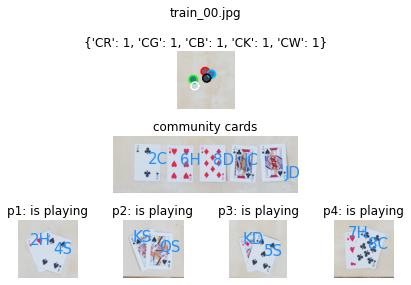


processing img 98:
-- 0.057 seconds to load image
-- segmenting image : 
---- 0.030 seconds to register table
ERR : table corners could not be detected
Assuming this means that a bad image was given as input


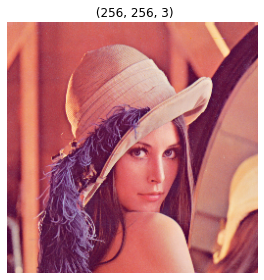

Breaking here and returning empty dict
0.183 seconds to process image 98

processing img 99:
-- 0.401 seconds to load image
-- segmenting image : 
---- 2.385 seconds to register table
---- 1.000 seconds to equalize table
---- 0.455 seconds to extract players
---- 0.000 seconds to extract community cards
---- 0.000 seconds to extract chips
-- 3.845 seconds to segment image
-- evaluating image : 
---- 0.620 seconds to count community cards
---- 1.230 seconds to count player cards
---- 1.972 seconds to count chips
-- 3.832 seconds to evaluate image
8.069 seconds to process image 99


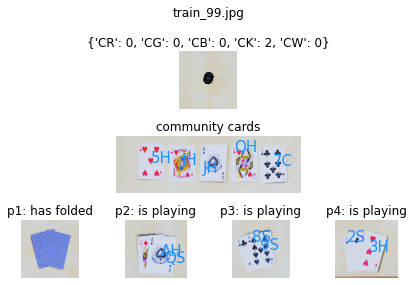

In [10]:
# demo of total program so far
for n in [0, 98, 99] : # a nominal image, a weird image and a nominal image
    print("\nprocessing img %d:" % n)

    tic = time.time()
    img = get_img(n)[::2,::2,:]
    print("-- %.3f seconds to load image" % (time.time() - tic))

    tic = time.time()
    results = process_image(img, save_intermed=False, n=n, show=True)
    print("%.3f seconds to process image %d" % (time.time() - tic, n))

    plt.show()
    
del img

### Testing Set

In [18]:
game_results = {}

# input definition
img_dir = 'train'
games_id = list(range(28))

# Evaluate images
for i in games_id :
    print("\nprocessing img %d:" % i)
    img = get_img(img_type=img_dir)[::2, ::2, :]
    # Process the image
    results = process_image(img)
    # Append result to array
    game_results[i] = results

# save the results to a file
file_results = save_results(results=game_results, groupid=37)


processing img 0:
-- segmenting image : 
---- 2.056 seconds to register table
---- 0.743 seconds to equalize table
---- 0.433 seconds to extract players
---- 0.000 seconds to extract community cards
---- 0.000 seconds to extract chips
-- 3.237 seconds to segment image
-- evaluating image : 
---- 1.684 seconds to count community cards
---- 2.296 seconds to count player cards
---- 1.280 seconds to count chips
-- 5.261 seconds to evaluate image

processing img 1:
-- segmenting image : 
---- 2.072 seconds to register table
---- 0.734 seconds to equalize table
---- 0.510 seconds to extract players
---- 0.000 seconds to extract community cards
---- 0.000 seconds to extract chips
-- 3.318 seconds to segment image
-- evaluating image : 
---- 2.054 seconds to count community cards
---- 2.830 seconds to count player cards
---- 1.581 seconds to count chips
-- 6.467 seconds to evaluate image

processing img 2:
-- segmenting image : 
---- 1.822 seconds to register table
---- 0.642 seconds to equal

---- 1.809 seconds to count community cards
---- 2.563 seconds to count player cards
---- 1.643 seconds to count chips
-- 6.021 seconds to evaluate image

processing img 19:
-- segmenting image : 
---- 2.091 seconds to register table
---- 0.913 seconds to equalize table
---- 0.424 seconds to extract players
---- 0.000 seconds to extract community cards
---- 0.000 seconds to extract chips
-- 3.431 seconds to segment image
-- evaluating image : 
---- 2.139 seconds to count community cards
---- 3.028 seconds to count player cards
---- 1.682 seconds to count chips
-- 6.853 seconds to evaluate image

processing img 20:
-- segmenting image : 
---- 2.176 seconds to register table
---- 0.731 seconds to equalize table
---- 0.391 seconds to extract players
---- 0.000 seconds to extract community cards
---- 0.000 seconds to extract chips
-- 3.307 seconds to segment image
-- evaluating image : 
---- 1.829 seconds to count community cards
---- 2.883 seconds to count player cards
---- 1.601 seconds 